# Disability at six months

In this notebook, we explore the completion of disability at six months and the change in disability between discharge and six months, and the factors associated with each of these.

The dataset contains information on:
* Disability before the stroke
* Disability at discharge
* Disability at six months

Disability is measured using the modified Rankin Scale (mRS). The scale ranges from 0 to 6, where 0 is perfect health without symptoms and 6 is death.

We know that disability (including death) at six months is input randomly (and so, case ascertainment is not more reliable for those died, but will vary between providers, as with the input of all mRS scores at 6 months).

## Caveats

**Follow-up is not missing at random**

Lots of patients are missing data on disability at six months, and this information is not missing at random. We know that the likelihood of having a follow-up assessment may be influenced by several different factors.

**Variation in follow up date**

SSNAP data is provided for patients with a "follow-up assessment at six months post admission (plus or minus two months). This means that the data can actually be from 4 to 8 months after admission, which is a large amount of variability. It is possible that this variation may not be random (and that certain patients are more or less likely to be followed up earlier or later).

**Variation in discharge date**

SSNAP data on disability after stroke is provided for the point of discharge, but different patients will have different lengths of stay (likely influenced by patient/clinical characteristics). This means we are comparing disability that could be at very different lengths of time after the stroke.

## Aims

* Investigate the completion of disability at six months (and associated factors)
* Investigate the change in disability between discharge and six months (and associated factors)

## Set up

In [1]:
# Import packages and functions
from collections import defaultdict
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             r2_score, confusion_matrix)

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Completion of data on disability at six months

**Remove patients dead at discharge**

Data on disability at six months will not be available for patients who were dead (mRS score of 6) at discharge. Therefore, we will remove them from the analysis, and focus only on patients who were alive at discharge.

Of all the patients in the SSNAP dataset:
* 13.9% were dead at discharge
* 85.4% had a disability score of 0 to 5
* 0.7% were missing data on disability at discharge

In [4]:
# Find proportion of patients with each discharge disability score
display(data_full['discharge_disability']
        .value_counts(dropna=False, normalize=True)
        .rename_axis('Discharge Disability')
        .sort_index()
        .reset_index(name='Proportion'))

,Discharge Disability,Proportion
0,0.0,0.129267
1,1.0,0.211068
2,2.0,0.181825
3,3.0,0.160238
4,4.0,0.115781
5,5.0,0.055937
6,6.0,0.138836
7,NaN,0.007047


In [5]:
# Remove patients who were dead at discharge
data_full_alive = data_full[data_full['death'] == 0].copy()

**Find proportion missing disability at discharge and/or six months**

Of all the patients in the SSNAP dataset who were not dead at discharge:
* 35.4% have data on disability at discharge and 6 months
* 63.8% are just missing disability at 6 months
* 0.8% are missing disability at discharge and 6 months

In [6]:
(data_full_alive[['discharge_disability', 'disability_6_month']]
 .isnull()
 .apply(lambda x: x.map({True: 'Missing', False: 'Not missing'}))
 .value_counts(normalize=True)
 .reset_index(name='proportion')
 .sort_values(by='disability_6_month', ascending=False))

,discharge_disability,disability_6_month,proportion
1,Not missing,Not missing,0.353737
0,Not missing,Missing,0.638119
2,Missing,Missing,0.008144


**Visualise completion of disability at 6 months by team**

The graph presents the proportion of patients who were not dead at discharge and are missing disability at six months. We can see there is **large variability** between teams, from 10.25% missing data to 99.95% missing data. 

count    119.000000
mean       0.641830
std        0.214977
min        0.102513
25%        0.486390
50%        0.635166
75%        0.802901
max        0.999516
Name: missing_6_month, dtype: float64

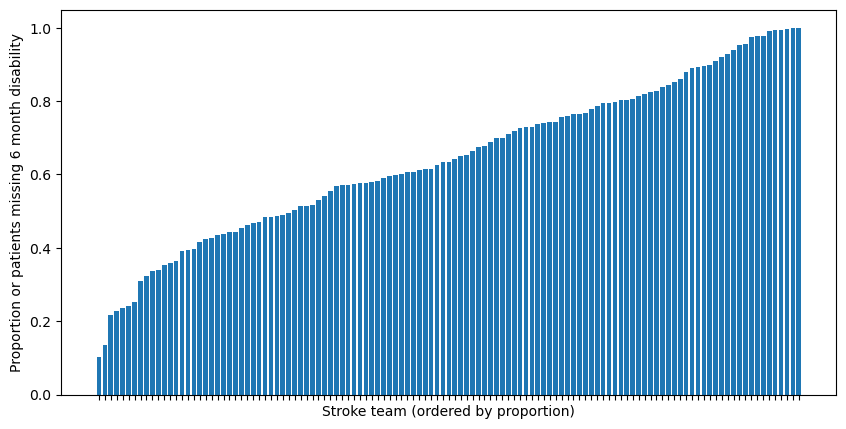

In [7]:
# Create columns where they are TRUE if missing disability
data_full_alive['missing_6_month'] = (
    data_full_alive['disability_6_month'].isnull())

# Find proportion missing disability
missing_6_month = (
    data_full_alive
    .groupby('stroke_team')['missing_6_month']
    .mean()
    .sort_values())

# Describe
display(missing_6_month.describe())

# Plot completion rate for 6 month disability in each team, ascending
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=missing_6_month.index,
       height=missing_6_month)
ax.set_xlabel('Stroke team (ordered by proportion)')
ax.set_ylabel('Proportion or patients missing 6 month disability')
ax.tick_params(labelbottom=False)
plt.show()

**Investigate whether completion is associated with size**

There appears to be no relationship between completion rate and the total patients who were alive at discharge.

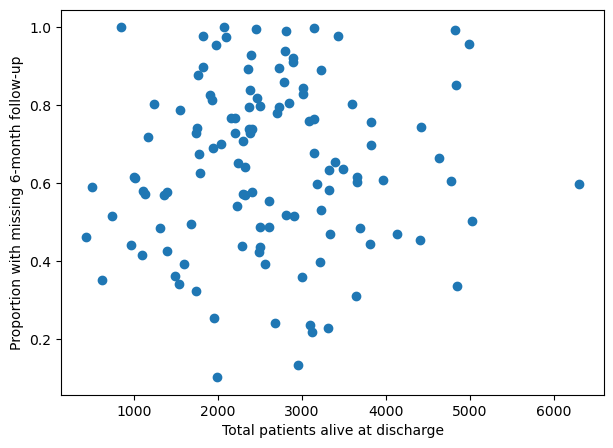

In [8]:
# Combine size with the proportion missing
team_size = (
    data_full_alive.groupby('stroke_team').size().rename('alive_at_discharge'))
team_followup_size = pd.concat([missing_6_month,
                                team_size], axis=1).reset_index()

# Find correlation
team_followup_size['alive_at_discharge'].corr(
    team_followup_size['missing_6_month'])

# Create scatter plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x=team_followup_size['alive_at_discharge'],
           y=team_followup_size['missing_6_month'])
ax.set_xlabel('Total patients alive at discharge')
ax.set_ylabel('Proportion with missing 6-month follow-up')
plt.show()

## Comparing patients with and without 6 month disability data

As above, this analysis only focusses on patients who were not marked as having died at discharge, else it would be an unfair comparison, as patients who died at discharge could not possibly have a six month follow up.

**Stroke severity**

There is a very small difference in mean stroke severity - 5.37 (followed up) and 5.51 (not followed up).


,count,mean,std,min,25%,50%,75%,max
missing_6_month,,,,,,,,
False,109321.0,5.370002,5.683979,0.0,2.0,3.0,7.0,42.0
True,199725.0,5.511238,5.949742,0.0,2.0,3.0,7.0,42.0


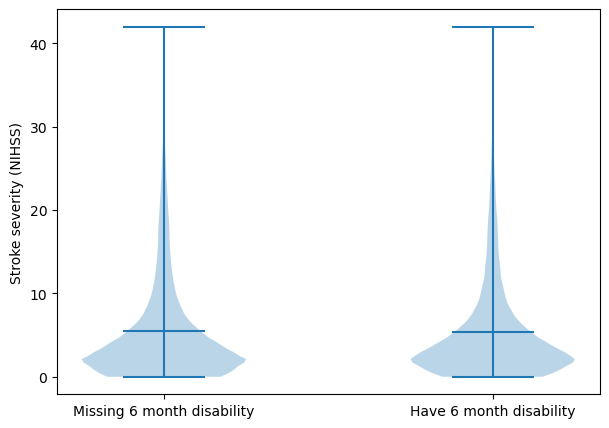

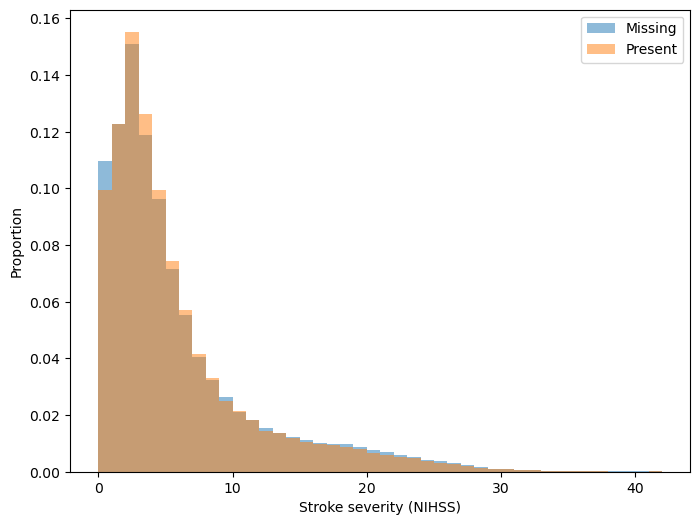

In [9]:
# Describe mean, median, IQR, etc. of stroke severity
display(
    data_full_alive.groupby('missing_6_month')['stroke_severity'].describe())

# Compare distribution of stroke severity results using violin plots
fig, ax = plt.subplots(figsize=(7, 5))
ax.violinplot([
    data_full_alive.loc[data_full_alive['missing_6_month'], 'stroke_severity'],
    data_full_alive.loc[~data_full_alive['missing_6_month'], 'stroke_severity']
    ], showmeans=True)
plt.xticks([1, 2], ['Missing 6 month disability', 'Have 6 month disability'])
ax.set_ylabel('Stroke severity (NIHSS)')
plt.show()

# Compare distributions using overlaid histograms
plot_missing = data_full_alive.loc[
    data_full_alive['missing_6_month'], 'stroke_severity']
plot_present = data_full_alive.loc[
    ~data_full_alive['missing_6_month'], 'stroke_severity']
plt.figure(figsize=(8, 6))
plt.hist(plot_missing, weights=np.ones(len(plot_missing)) / len(plot_missing),
         bins=np.arange(0, 43, 1), alpha=0.5, label="Missing")
plt.hist(plot_present, weights=np.ones(len(plot_present)) / len(plot_present),
         bins=np.arange(0, 43, 1), alpha=0.5, label="Present")
plt.xlabel('Stroke severity (NIHSS)')
plt.ylabel('Proportion')
plt.legend()
plt.show()

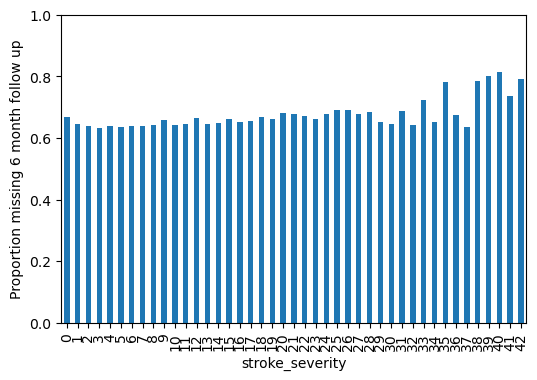

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
(data_full_alive
 .groupby('stroke_severity')['missing_6_month']
 .mean()
 .plot(kind='bar', ax=ax))
ax.set_ylabel('Proportion missing 6 month follow up')
ax.set_ylim([0, 1])
plt.show()

**Thrombolysed**

A slightly higher proportion of thrombolysed patients have follow up, although this difference may be smaller than anticipated.

,thrombolysis,missing_6_month,proportion
0,0,True,0.647322
1,0,False,0.352678
2,1,True,0.638126
3,1,False,0.361874


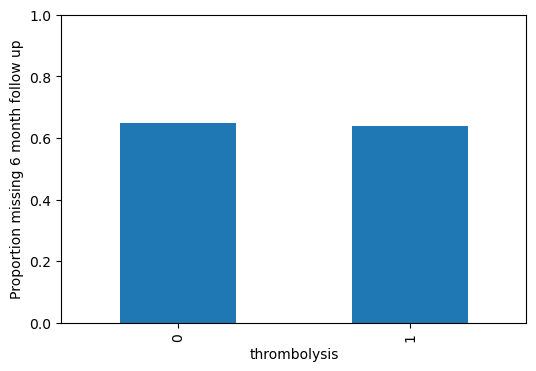

In [11]:
display(data_full_alive
        .groupby('thrombolysis')['missing_6_month']
        .value_counts(normalize=True)
        .reset_index(name='proportion'))

fig, ax = plt.subplots(figsize=(6, 4))
(data_full_alive
 .groupby('thrombolysis')['missing_6_month']
 .mean()
 .plot(kind='bar', ax=ax))
ax.set_ylabel('Proportion missing 6 month follow up')
ax.set_ylim([0, 1])
plt.show()

**Infarction**

,infarction,missing_6_month,proportion
0,0.0,True,0.653785
1,0.0,False,0.346215
2,1.0,True,0.645511
3,1.0,False,0.354489


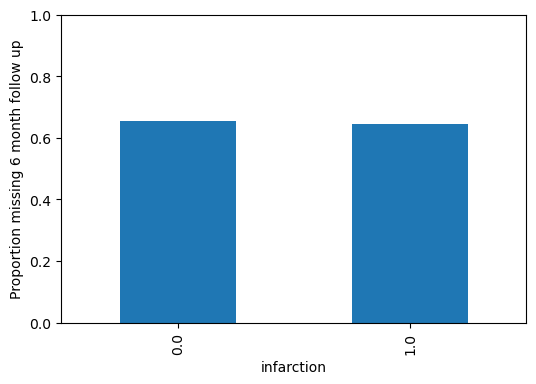

In [12]:
display(data_full_alive
        .groupby('infarction')['missing_6_month']
        .value_counts(normalize=True)
        .reset_index(name='proportion'))

fig, ax = plt.subplots(figsize=(6, 4))
(data_full_alive
 .groupby('infarction')['missing_6_month']
 .mean()
 .plot(kind='bar', ax=ax))
ax.set_ylabel('Proportion missing 6 month follow up')
ax.set_ylim([0, 1])
plt.show()

**Prior disability**

,prior_disability,missing_6_month,proportion
0,0,True,0.641965
1,0,False,0.358035
2,1,True,0.625371
3,1,False,0.374629
4,2,True,0.647275
5,2,False,0.352725
6,3,True,0.672922
7,3,False,0.327078
8,4,True,0.698523
9,4,False,0.301477


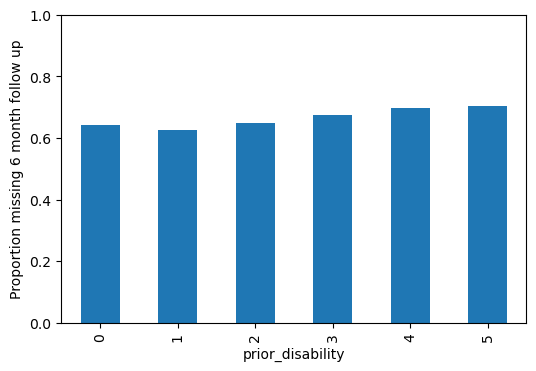

In [13]:
display(data_full_alive
        .groupby('prior_disability')['missing_6_month']
        .value_counts(normalize=True)
        .reset_index(name='proportion'))

fig, ax = plt.subplots(figsize=(6, 4))
(data_full_alive
 .groupby('prior_disability')['missing_6_month']
 .mean()
 .plot(kind='bar', ax=ax))
ax.set_ylabel('Proportion missing 6 month follow up')
ax.set_ylim([0, 1])
plt.show()

**Age**

,age,missing_6_month,proportion
0,37.5,True,0.717289
1,37.5,False,0.282711
2,42.5,True,0.693690
3,42.5,False,0.306310
4,47.5,True,0.694955
5,47.5,False,0.305045
6,52.5,True,0.679575
7,52.5,False,0.320425
8,57.5,True,0.658418
9,57.5,False,0.341582


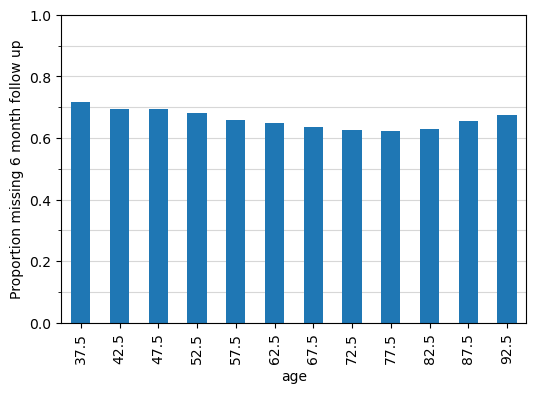

In [14]:
display(data_full_alive
        .groupby('age')['missing_6_month']
        .value_counts(normalize=True)
        .reset_index(name='proportion'))

fig, ax = plt.subplots(figsize=(6, 4))
(data_full_alive
 .groupby('age')['missing_6_month']
 .mean()
 .plot(kind='bar', ax=ax))
ax.set_ylabel('Proportion missing 6 month follow up')
ax.set_ylim([0, 1])
ax.set_yticks(np.arange(0, 1, 0.1), minor=True)
ax.grid(axis='y', which='minor', alpha=0.5)
ax.grid(axis='y', which='major', alpha=0.5)
ax.set_axisbelow(True)
plt.show()

### Change in disability between discharge and 6-month follow-up

In [15]:
def disability_change(df):
    # Change in mRS score from discharge to 6 months later
    mrs_6m = ((df['disability_6_month'] - df['discharge_disability'])
              .dropna().describe())

    print(f'''From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is {mrs_6m.squeeze()['mean']:.1f}''')
    display(mrs_6m)


def plot_disability_change(df):
    # Extract individuals with complete data at followup
    mrs_compare = (df[['disability_6_month', 'discharge_disability']]
                   .dropna()
                   .rename(columns={'disability_6_month': 'followup',
                                    'discharge_disability': 'discharge'}))

    # Compare 6 month disability to discharge disability
    mrs_compare['compare'] = np.where(
        mrs_compare['followup'] > mrs_compare['discharge'], 'Worse',
        np.where(mrs_compare['followup'] < mrs_compare['discharge'],
                 'Better', 'Same'))

    # Find proportion better, same or worse - by discharge disability
    mrs_compare_3 = (
        mrs_compare.groupby('discharge')['compare']
        .value_counts(normalize=True, dropna=True)
        .reset_index(name='prop')
        .sort_values(by=['discharge', 'compare'])
        .pivot(index='discharge',
               columns='compare',
               values='prop')
        .fillna(0))

    # Plot these results
    fig, ax = plt.subplots(figsize=(9, 6))
    mrs_compare_3.plot.bar(ax=ax)
    ax.set_xlabel('Discharge disability')
    ax.set_ylabel('Proportion of patients')
    ax.legend(title='Disability at 6 months (compared to discharge)',
              loc='upper center', ncol=3)
    ax.set_title('For each discharge mRS score, proportion of patients' +
                 '\nwho had better, same or worse score at 6-month follow-up')
    plt.show()


def plot_follow_up_by_discharge(df):
    # Find proportion with each disability at 6 months,
    # grouped by discharge disability
    followup = (df
                .groupby('discharge_disability')['disability_6_month']
                .value_counts(normalize=True, dropna=True)
                .reset_index(name='prop')
                .sort_values(by=['discharge_disability',
                                 'disability_6_month']))

    # Pivot those results so they're suitable for plot
    followup_p = (followup
                  .dropna()
                  .pivot(columns='disability_6_month',
                         index='discharge_disability',
                         values='prop'))

    # Display dataframe
    display(followup_p)

    # Create plot (line plot as easier to see difference in proportions)
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(followup_p.T, marker='o')
    ax.set_xlabel('Disability at 6-month follow-up (mRS score)')
    ax.set_ylabel('Proportion of patients')
    ax.legend(ax.get_lines(), followup_p.columns, loc='best',
              title='Discharge disability', ncol=2)
    ax.set_title('Proportion of patients with each 6-month disability score' +
                 '\n(grouped by their discharge disability score)')
    ax.grid()
    plt.show()

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(9, 6))
    followup_p.reset_index().plot(
        x='discharge_disability', kind='bar', stacked=True, ax=ax)
    ax.set_xlabel('Discharge disability')
    ax.set_ylabel('Proportion')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              title='Disability at 6 months')
    plt.title('Proportion of patients with each 6-month disability score\n' +
              '(grouped by their discharge disability)')
    plt.show()

**Observations:**
* We see that Rankin score from discharge to follow-up is, on average, the **same** (median) or **worse** (mean) (focussing only on people who have measurements at both time points). This is contrary to a comment received, that we would expect people to, on average, be 1 unit better.
* Majority of patients with discharge score of 0 or 5 are worse
* Majority of patients with discharge score of 2, 3, or 4 are better

Caveats include:
* Data is not missing at random
* mRS is an ordinal scale (i.e. they have an order but there is not a consistent space on the scale between each score) (hence why some of the other analyses on SAMueL2 use utility values)

From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is 0.1


count    109321.00000
mean          0.11533
std           1.52376
min          -5.00000
25%          -1.00000
50%           0.00000
75%           1.00000
max           6.00000
dtype: float64

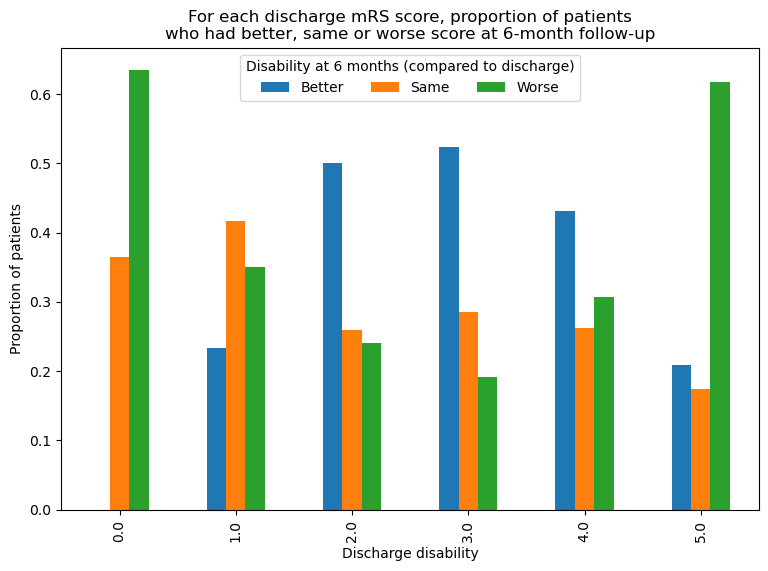

disability_6_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0
discharge_disability,,,,,,,
0.0,0.364742,0.355824,0.154839,0.077014,0.014405,0.003367,0.029808
1.0,0.233916,0.416034,0.193437,0.100229,0.019308,0.002866,0.034210
2.0,0.153271,0.347847,0.259056,0.154653,0.031671,0.004797,0.048705
3.0,0.073908,0.216464,0.233388,0.285305,0.081604,0.012429,0.096902
4.0,0.019991,0.073859,0.111151,0.225792,0.261922,0.078220,0.229064
5.0,0.003608,0.011971,0.013283,0.038537,0.141850,0.173991,0.616760


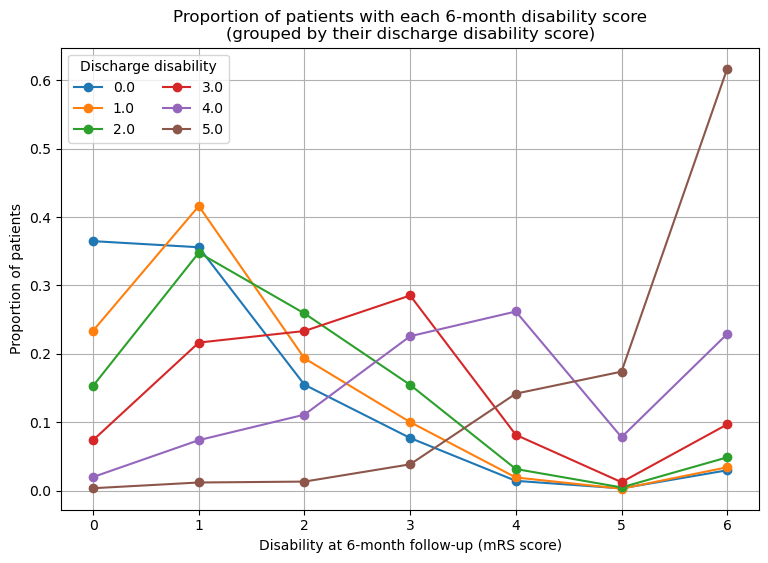

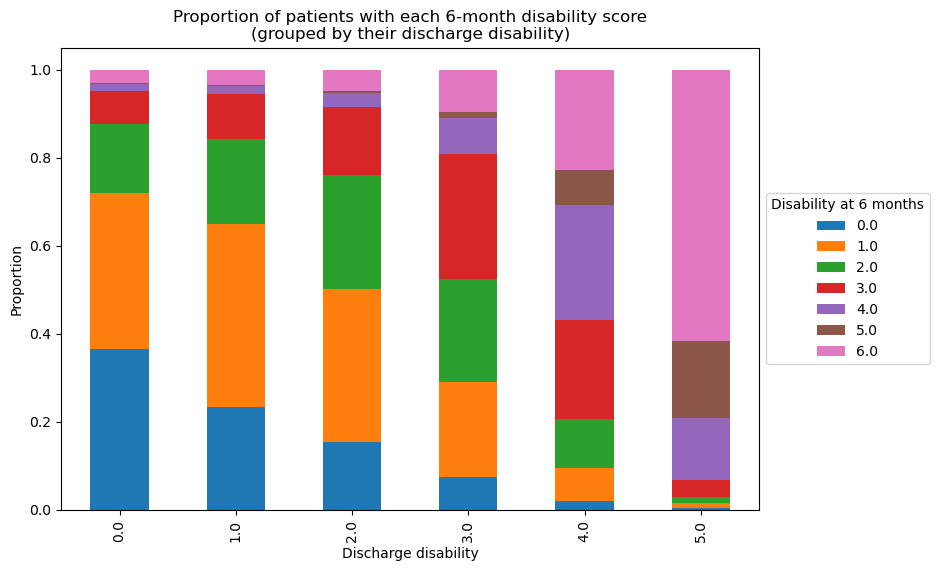

In [16]:
disability_change(data_full)
plot_disability_change(data_full)
plot_follow_up_by_discharge(data_full)

**EXCLUDING those who are marked as having died at 6 months**, the mean change in mRS is -0.2 (i.e. a slight improvement)

In [17]:
# Filter to patients who were alive at discharge AND follow-up
not_dead = data_full_alive[data_full_alive['disability_6_month'] != 6]

print('For patients with disability at discharge and 6 months')
print('who had arrived within 4 hours of known stroke onset...\n')
disability_change(not_dead)

For patients with disability at discharge and 6 months
who had arrived within 4 hours of known stroke onset...

From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is -0.2


count    97751.000000
mean        -0.163385
std          1.270598
min         -5.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          5.000000
dtype: float64

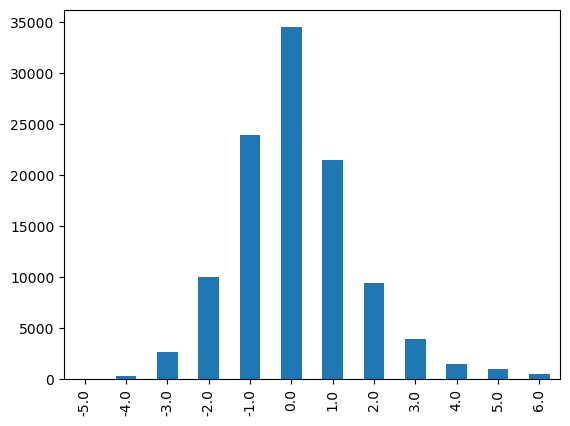

In [18]:
mrs_6m = ((data_full_alive['disability_6_month'] -
           data_full_alive['discharge_disability']).dropna())
mrs_6m.value_counts().sort_index().plot(kind='bar')
plt.show()

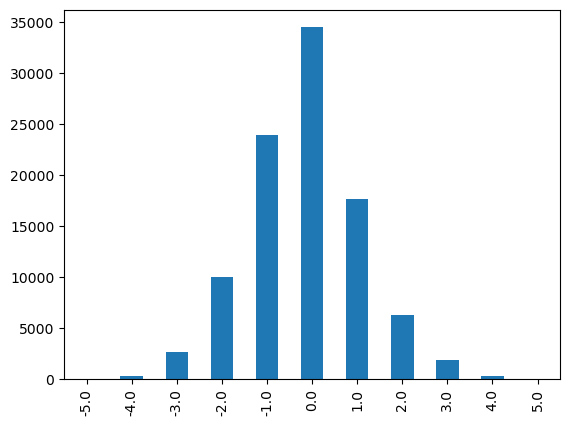

In [19]:
mrs_6m = ((not_dead['disability_6_month'] -
           not_dead['discharge_disability']).dropna())
mrs_6m.value_counts().sort_index().plot(kind='bar')
plt.show()

## Regression (change in disability)

Multiple linear regression model, with estimation using ordinary least squares (OLS).

Caveat:
* Data is not missing at random
* mRS score is ordinal scale

### Dataset

The dataset is patients who arrived within 4 hours of known onset, and who have complete data at each disability timepoint, as well as for stroke severity, age and whether thrombolysed.

In those model, we are predicting change in disability from discharge to six month follow up.

In [20]:
# Extract relevant columns and drop rows with NA
reg_df = data_full[['prior_disability', 'stroke_severity', 'age',
                    'thrombolysis', 'discharge_disability',
                    'disability_6_month']].dropna().reset_index()
display(reg_df.shape)

# Define predictor and response variables
X = reg_df[['prior_disability', 'stroke_severity', 'age',
            'thrombolysis', 'discharge_disability']]
y = reg_df['disability_6_month'] - reg_df['discharge_disability']

(109321, 7)

### Transform data, fit model, and collect evaluation metrics

In [21]:
def standardise_data(X_train, X_test):
    '''
    Put features on a similar scale through standardisation.
    Just transforms features (not response/target variable).
    Invovles subtracting mean and dividing by standard deviation (SD)
    of each feature, so data have mean of 0 and SD of 1.
    Test data is standardised on training data mean and SD.
    '''

    # Set up scaling object and fit on training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Apply scaling to training and test data
    train_std = sc.transform(X_train)
    test_std = sc.transform(X_test)

    return train_std, test_std

In [22]:
def run_regression(standardise):
    '''
    Run regression with 5-fold cross-validation
    Can choose whether to standardise input variables or not
    Returns MAE, MSE, RMSE, R2, adjusted R2, feature weights and residuals
    standardise: True or False
    '''
    # Set up to create five training/test data splits
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    # Create empty dictionary to store results
    # (defaultdict so don't have to pre-define keys)
    reg_results = defaultdict(list)

    # Use loop to test model on those five different splits
    for train_row, test_row in kfold.split(X):
        # Split into training and test data
        X_train, X_test = X.iloc[train_row], X.iloc[test_row]
        y_train, y_test = y[train_row], y[test_row]

        if standardise:
            # Standardise X data
            X_train, X_test = standardise_data(X_train, X_test)

        # Set up and fit multiple linear regression
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Get feature weights
        reg_results['feature_weights'].append(model.coef_)

        # Predict y values using the x test values
        y_test_pred = model.predict(X_test)

        # Find residuals (difference between prediction and actual)
        resid = pd.DataFrame({'actual': y_test,
                              'pred': y_test_pred})
        resid['residuals'] = abs(resid['actual']) - abs(resid['pred'])
        reg_results['residuals'].append(resid)

        # Use predictions to calculate evaluation metrics
        reg_results['mae'].append(mean_absolute_error(y_test, y_test_pred))
        mse = mean_squared_error(y_test, y_test_pred)
        reg_results['mse'].append(mse)
        reg_results['rmse'].append(np.sqrt(mse))
        reg_results['r2'].append(r2_score(y_test, y_test_pred))
        adjusted_r2 = (1 -
                       (1 - model.score(X_train, y_train)) *
                       (len(y_train)-1) /
                       (len(y_train)-X_train.shape[1]-1))
        reg_results['adjusted_r2'].append(adjusted_r2)

    return (reg_results)

In [23]:
# Run with X variables standardised
reg_results = run_regression(standardise=True)

# Run without standardisation
reg_results_non_std = run_regression(standardise=False)

### Review results

In [24]:
def show_regression_results(results):
    '''
    Summarise results from regression, based on results dictionary input
    '''
    # Table of coefficients (as is, and absolute)
    coef = pd.DataFrame(results['feature_weights'], columns=X.columns)
    mean_coef = pd.DataFrame({'coef': coef.mean(),
                              'coef_abs': abs(coef.mean())})
    mean_coef_sort = mean_coef.sort_values(by='coef_abs', ascending=False)
    display(mean_coef_sort)

    # Plot of feature weights
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.bar(mean_coef_sort.index, mean_coef_sort['coef'])
    ax.set_xlabel('Feature')
    ax.set_ylabel('Coefficient')
    plt.xticks(rotation=45)
    plt.show()

    # Metrics
    print(f'''
          Average MAE: {np.mean(results['mae']):.9f}
          Average RMSE: {np.mean(results['rmse']):.9f}
          Average R-squared: {np.mean(results['r2']):.9f}
          Average adjusted R-squared: {np.mean(results['adjusted_r2']):.9f}''')

#### Standardised results

**Understanding outcome score**

Outcome is change in disability score between discharge and six-month follow-up (disability_6_month - discharge_disability). **A negative result means that score improved.** A positive result means that the score worsened.

*Example: Patient sees improvement. They have mRS 3 at discharge and mRS 2 at 6-month. Their outcome would be negative, as score has gone down (2 - 3 = -1).*

**Interpreting the coefficients**

These are standardised - they are in units of standard deviation - and hence you can compare the relative importance of each variable, as they are on the same scale. Standardised coefficients reflect the change in outcome (in terms of standard deviation) for every increase of one standard deviation in the predictor.

* **Discharge disability** and **thrombolysis** have negative coefficients. This means that having a higher discharge disability, and receiving thrombolysis, are associated with an **improvement** in disability between discharge and follow-up (a negative change in score).
* **Prior disability**, **stroke severity** and **age** have positive coefficients. This means that having a higher prior disability, higher stroke severity, and older age, are associated with a **worsening** in disability between discharge and follow-up (a positive change in score).
* Discharge disability largest, so greatest relative importance.

**Note:** If you have a higher discharge disability, you have **more scope to improve** (e.g. mRS 5 can go down to mRS 1, but mRS 1 can change by a max of 1 to mRS 0). Hence, it is essentially an artefact of the scale and the scope to change. This analysis may therefore feel unhelpful - but should consider that it is still helpful in thinking through what is going on in the data.

**Interpreting the metrics**
* **MAE**: Mean absolute error. Calculation is to find average of the residuals (which themselves are the difference between actual and predicted values). Lower value implies higher accuracy. Difficult to interpret as generally about comparing accuracy between models and depends on scale in dataset.
* **RMSE**: Square root of variance of residuals. Average distance between predicted and observed values. It shows absolute fit of model. Likewise hard to interpret without comparison.
* **R-squared**: Relatived fit of model. Also known as coefficient of multiple determination. Percentage of variance explained (variance explained by the model over the total variance). R squared of 17% means that model explains 17% of variation in response variable around the mean.
* **Adjusted R-squared:** Important in multiple regression. Issue with R-squared is that it increases with every predictor added to the model, so you may think you have a better fit, the more terms you add, which is misleading. Adjusted R-squared is adjusted for the number of independent variables in the model. It will increase if useful variables are added to the model and decrease if useless variables are added.

,coef,coef_abs
discharge_disability,-0.789904,0.789904
prior_disability,0.414582,0.414582
stroke_severity,0.331800,0.331800
age,0.190118,0.190118
thrombolysis,-0.111061,0.111061


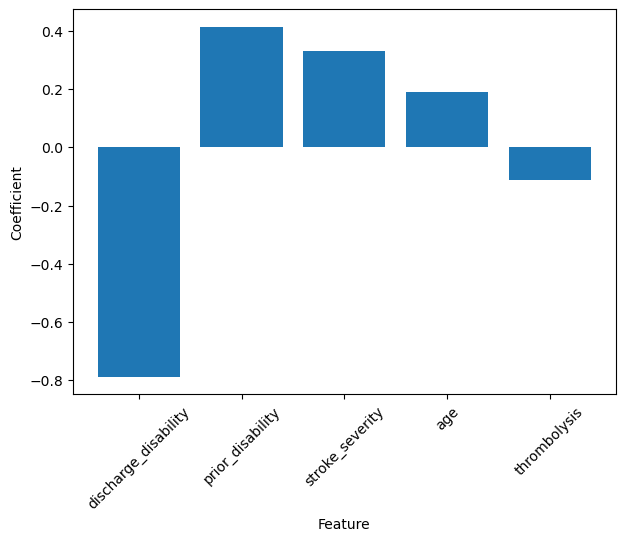


          Average MAE: 1.048413108
          Average RMSE: 1.378388463
          Average R-squared: 0.181646840
          Average adjusted R-squared: 0.181804322


In [25]:
# Standardised prior to regression
show_regression_results(reg_results)

#### Unstandardised results

**Interpreting the coefficients**

These variables were not standardised, so the coefficients are in their original units.  The coefficients represent the change in the outcome variable, for every one unit increase in the predictor, when the value of all other predictors is held constant. It shows that the relationship remains even when you control for other variables. It does not provide evidence for/against a causal relationship. The **direction of relationships is the same** as in the standardised regression.

Examples:
* **Thrombolysis** coefficient -0.28 means that, on average, if you had thrombolysis, you have a 0.28 improvement in mRS score between discharge and follow-up (association not causal, and of people who were followed up)
* **Discharge disability** coefficient -0.51 means having a one mRS score higher discharge disability associates with an improvement of 0.51 in mRS score between discharge and follow-up

**Interpreting the metrics**

These are the same as the metrics when unstandardised variables were used. Why is that?
* Is it because scikit learn standardise for you anyway? No, they don't do this, we checked the documentation and model code.
* Is it as this is a large dataset?
* Is it as there isn't huge variation in scales between the variables?

,coef,coef_abs
discharge_disability,-0.553723,0.553723
thrombolysis,-0.344529,0.344529
prior_disability,0.331157,0.331157
stroke_severity,0.058376,0.058376
age,0.014761,0.014761


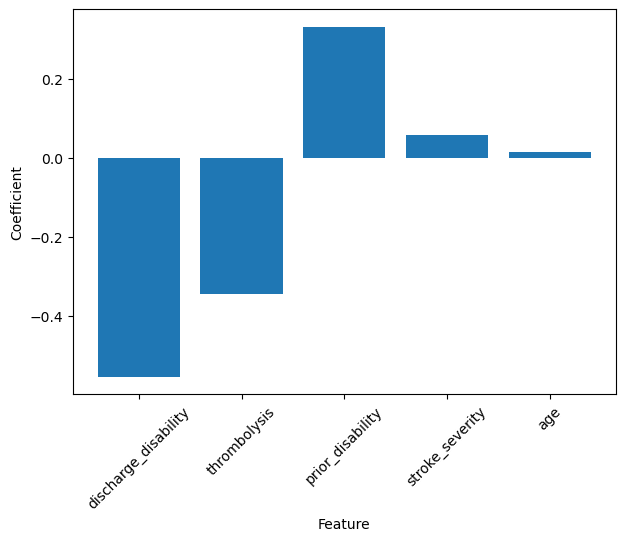


          Average MAE: 1.048413108
          Average RMSE: 1.378388463
          Average R-squared: 0.181646840
          Average adjusted R-squared: 0.181804322


In [26]:
# Did not standardise prior to regression
show_regression_results(reg_results_non_std)

### Assumptions

In [27]:
# Look at relationship between actual and predicted values
def test_linear(df):
    '''
    Test assumption of linearity.
    df is dataframe containing columns with predicted and actual
    values of the response variable.
    '''
    # Plot actual and predicted values
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(df['actual'], df['pred'])
    ax.set_xlabel('Actual value')
    ax.set_ylabel('Predicted value')

    # Add diagonal line (based on overall min and max)
    line_coords = (df.min().min(), df.max().max())
    ax.plot(line_coords, line_coords, ls='--')

    plt.show()


def test_assumptions(X, reg_results):
    '''
    Tests assumptions of multiple linear regression
    X: dataframe where each column is a predictor variable
    reg_results: dictionary output by regression
    '''
    # Test for linear relationship between each predictor and outcome
    print('Linearity - look at relationship between each predictor and ' +
          'outcome - or look at\nrelationship between predicted and actual ' +
          'values (linearity indicated by even spread around diagnoal line)')

    # Look at linear relationship between each predictor and outcome
    fig, ax = plt.subplots(nrows=1, ncols=len(X.columns), figsize=(15, 3))
    for i in np.arange(len(X.columns)):
        ax[i].scatter(X.iloc[:, i], y)
        ax[i].set_xlabel(X.columns[i])
        ax[i].set_ylabel('Change in disability from\ndischarge to followup')
    fig.tight_layout()
    plt.show()

    # Just plot from first train/test split
    test_linear(reg_results['residuals'][0])

    # Look at averages (if scatter not meaningful for linearity)
    fig, ax = plt.subplots(nrows=1, ncols=len(X.columns), figsize=(15, 3))
    for i in np.arange(len(X.columns)):
        averages = X.groupby(y)[X.columns[i]].mean()
        averages.plot(marker='.', ax=ax[i])
        ax[i].set_xlabel('Change in mRS from discharge\n' +
                         'to 6-month follow-up')
        ax[i].set_ylabel(X.columns[i])
    fig.tight_layout()
    plt.show()

    # Test for normally distributed residuals
    print('Normally distributed residuals:')
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(reg_results['residuals'][0]['residuals'],
            edgecolor='black', bins=20)
    plt.show()

    # Test for independent observations (just review manually)
    print('Independent observations: review manually\n')

    # Test for homoscedasticity
    print('Homoscedasticity - should be no patterns in distributions of' +
          'residuals - i.e. the size of error\nshould not relate to' +
          'the value of the outcome variable):')
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(reg_results['residuals'][0].index,
               reg_results['residuals'][0].residuals,
               s=0.5)
    plt.show()

    # Test for multicolinearity
    print('Multicolinearity - if there is multicolinearity present, it ' +
          'will result in less precise estimates of individual\n' +
          'regression parameters (difficult to decide precisely what' +
          'each variable contributes) (unstable estimates, may vary\n' +
          'alot with addition or removal of data points) (larger' +
          'sample sizes can better handle multicolinearity)')
    display(round(X.corr(), 2))

    # Create figure object
    fig, ax = plt.subplots(figsize=(4, 4))

    # Set colours
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        '', ['red', 'white', 'blue'])
    norm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)

    # Create heatmap
    heatmap = ax.imshow(X.corr(), cmap=cmap, norm=norm)

    # Add legend for colours
    fig.colorbar(heatmap)

    # Show plot
    plt.show()

**Observations:**
* Linearity - not really
* Normally distributed residuals - no (slight left skew)
* Independent observations - yes (as each row is different patient)
* Homoscedasticity - yes, appears so
* Multicolinearity - alright, max is 0.5, so doesn't appear to be problematic colinearity

Linearity - look at relationship between each predictor and outcome - or look at
relationship between predicted and actual values (linearity indicated by even spread around diagnoal line)


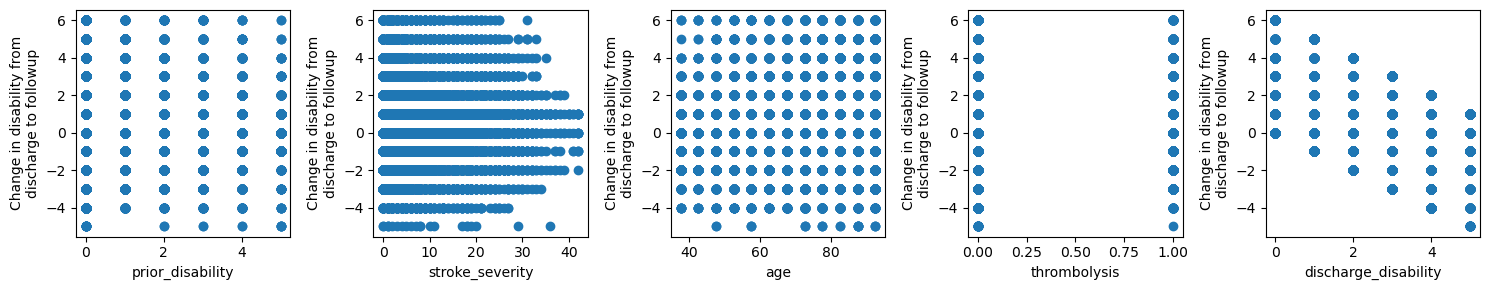

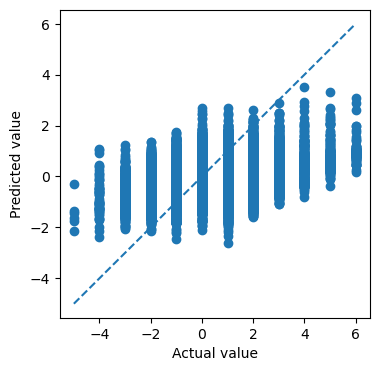

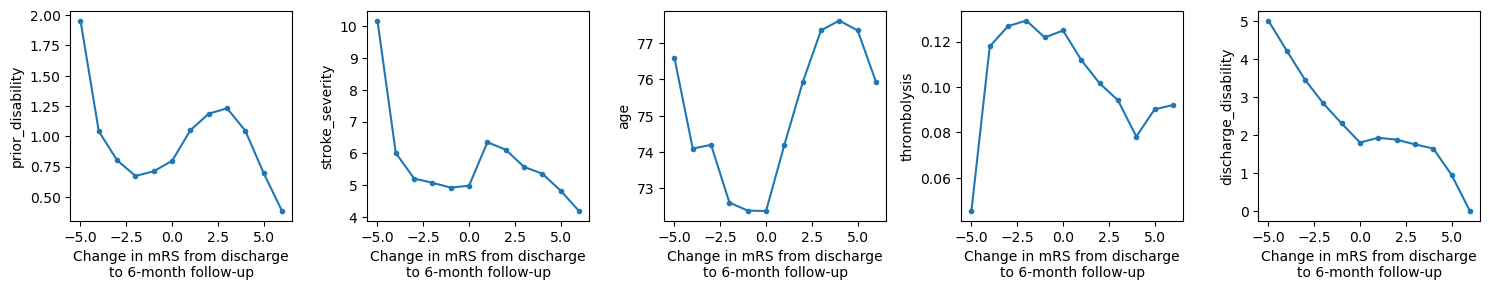

Normally distributed residuals:


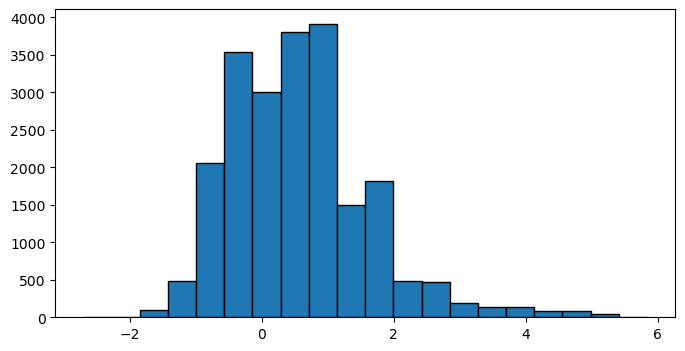

Independent observations: review manually

Homoscedasticity - should be no patterns in distributions ofresiduals - i.e. the size of error
should not relate tothe value of the outcome variable):


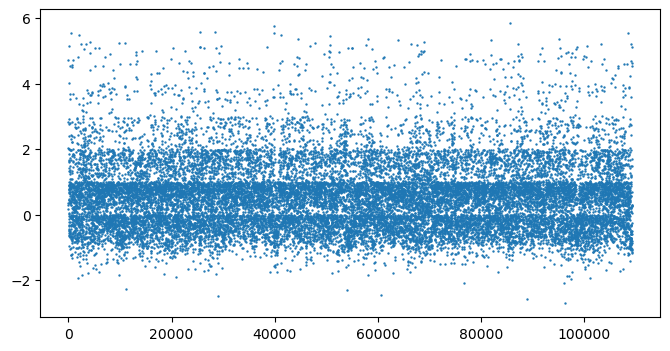

Multicolinearity - if there is multicolinearity present, it will result in less precise estimates of individual
regression parameters (difficult to decide precisely whateach variable contributes) (unstable estimates, may vary
alot with addition or removal of data points) (largersample sizes can better handle multicolinearity)


,prior_disability,stroke_severity,age,thrombolysis,discharge_disability
prior_disability,1.00,0.21,0.33,-0.08,0.51
stroke_severity,0.21,1.00,0.10,0.29,0.42
age,0.33,0.10,1.00,-0.04,0.29
thrombolysis,-0.08,0.29,-0.04,1.00,-0.02
discharge_disability,0.51,0.42,0.29,-0.02,1.00


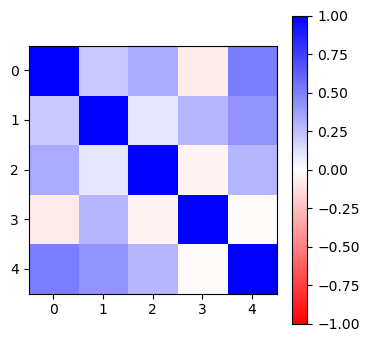

In [28]:
test_assumptions(X, reg_results)

## Regression (whether have follow-up appointment)

Multiple logistic regression model.

### Dataset

The dataset is patients who arrived within 4 hours of known onset, and who have complete data data for discharge disability, stroke severity, age and whether thrombolysed. They can have incomplete data for 6-month follow-up (as that is what we are predicting).

In [29]:
# Extract relevant columns, resetting index else set on slice
reg_df = data_full[['prior_disability', 'stroke_severity', 'age',
                    'thrombolysis', 'discharge_disability']].reset_index(drop=True)

# Create column of whether had follow-up
reg_df['6_month_complete'] = (
    data_full['disability_6_month'].isnull().map({False: 1, True: 0}))
display(reg_df['6_month_complete'].value_counts(normalize=True))

# Drop NA
reg_df = reg_df.dropna().reset_index(drop=True)
display(reg_df.shape)

# Define predictor and response variables
X = reg_df[['prior_disability', 'stroke_severity', 'age',
            'thrombolysis', 'discharge_disability']]
y = reg_df['6_month_complete']

0    0.695386
1    0.304614
Name: 6_month_complete, dtype: float64

(356355, 6)

3:80: E501 line too long (83 > 79 characters)


In [30]:
def logistic_regression(standardise):
    '''
    Run logistic regression with 5-fold cross-validation
    Can choose whether to standardise input variables or not
    Returns MAE, MSE, RMSE, R2, adjusted R2, feature weights and residuals
    '''
    # Set up to create five training/test data splits
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    # Create empty dictionary to store results
    # (defaultdict so don't have to pre-define keys)
    reg_results = defaultdict(list)

    # Use loop to test model on those five different splits
    for train_row, test_row in kfold.split(X):
        # Split into training and test data
        X_train, X_test = X.iloc[train_row], X.iloc[test_row]
        y_train, y_test = y[train_row], y[test_row]

        if standardise:
            # Standardise X data
            X_train, X_test = standardise_data(X_train, X_test)

        # Set up and fit multiple linear regression
        model = LogisticRegression()
        model.fit(X_train, y_train)

        # Get feature weights
        reg_results['feature_weights'].append(model.coef_)

        # Get accuracy
        reg_results['accuracy'] = model.score(X_test, y_test)

        # Get confusion matrix
        predictions = model.predict(X_test)
        reg_results['confusion'] = confusion_matrix(y_test, predictions)

    return (reg_results)

Predicts everything to not be a follow-up as that is majority in dataset.

In [31]:
logistic_regression(True)

defaultdict(list,
            {'feature_weights': [array([[ 0.04656685, -0.13427037,  0.07747488,  0.04044917, -0.46130055]]),
              array([[ 0.04511475, -0.1328435 ,  0.07879367,  0.03787641, -0.45563004]]),
              array([[ 0.04239823, -0.13610947,  0.07885667,  0.04281216, -0.45526751]]),
              array([[ 0.04392537, -0.13297785,  0.07556136,  0.03773259, -0.45832226]]),
              array([[ 0.0408941 , -0.13453528,  0.07800657,  0.04224722, -0.45412759]])],
             'accuracy': 0.6920486593425096,
             'confusion': array([[49307,     8],
                    [21940,    16]])})